In [1]:
import urllib.request

import geopandas
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd
import planetary_computer
import pystac_client
import rioxarray
import xarray as xr
import odc.stac
import dask.distributed

In [2]:
from shapely import wkt

In [3]:
# https://boundingbox.klokantech.com/

region = wkt.loads(
    "POLYGON((-58.611677 -34.469254, -58.271327 -34.469254, -58.271327 -34.725584, -58.611677 -34.725584, -58.611677 -34.469254))"
)
bbox = region.bounds

In [9]:
start = pd.Timestamp("2020-01-01")
stop = pd.Timestamp("2020-01-03")

In [10]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)

#filter_query = {"eo:cloud_cover": {"lte": 20}}

query = catalog.search(
    collections=["sentinel-5p-l2-netcdf"],
    datetime=[start, stop],
    limit=100,  # Consider making this configurable
    bbox=bbox,
#    query=filter_query
)

items = list(query.items())

In [11]:
len(items)

36

In [16]:
items[0]

<Item id=S5P_L2_SO2____20200102T172846_20200102T191016_11511>

In [17]:
bands = ["so2"]

In [40]:
ds = odc.stac.load(items, bands=bands, chunks={}, intersects=region, resolution=1)

In [45]:
ds.mean().compute()

/Users/jeronimoluza/Library/Caches/pypoetry/virtualenvs/envineq-JO171pb8-py3.10/lib/python3.10/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


ValueError: Requested band 1 from https://sentinel5euwest.blob.core.windows.net/sentinel-5p/TROPOMI/L2__SO2___/2020/01/02/S5P_OFFL_L2__SO2____20200102T172846_20200102T191016_11511_01_010107_20200104T194401/S5P_OFFL_L2__SO2____20200102T172846_20200102T191016_11511_01_010107_20200104T194401.nc?st=2025-06-09T15%3A41%3A14Z&se=2025-06-10T16%3A26%3A14Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-06-09T09%3A00%3A00Z&ske=2025-06-16T09%3A00%3A00Z&sks=b&skv=2024-05-04&sig=mW//YNEWmmsM6CqpIaYIVVJbBnGS9AM4PoHbTj0wrds%3D with only 0 bands

In [12]:
def compute_ndvi(ds, ndvi_bands, resolution=10):
    """
    Loads 'red' and 'nir' bands and computes NDVI.
    Assumes that odc.stac.load handles scale/offset factors from STAC metadata.

    Args:
        resolution (int): Spatial resolution for loading bands.

    Returns:
        xarray.DataArray: Calculated NDVI, or None if bands could not be loaded.
    """
    
    bands_dataset = ds.copy()
    # Ensure all bands are float and compute
    for band_name in ndvi_bands:
        if band_name in bands_dataset:
            bands_dataset[band_name] = bands_dataset[band_name].astype(float, copy=False).compute()

    if bands_dataset is None or not bands_dataset.data_vars:
        print("Could not load 'red' and 'nir' bands for NDVI calculation.")
        return None
    
    if "nir" not in bands_dataset:
        print("Error: 'nir' band not found in loaded dataset.")
        return None
    if "red" not in bands_dataset:
        print("Error: 'red' band not found in loaded dataset.")
        return None

    nir_band = bands_dataset["nir"]
    red_band = bands_dataset["red"]

    ndvi = (nir_band - red_band) / (nir_band + red_band)
    ndvi.name = "ndvi"

    return ndvi

In [13]:
ndvi_bands = ['red','nir']

In [14]:
ndvi = odc.stac.load(items, bands=ndvi_bands, chunks={}, groupby='solar_day', intersects=region)

In [15]:
ndvi = compute_ndvi(ndvi, ndvi_bands)

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

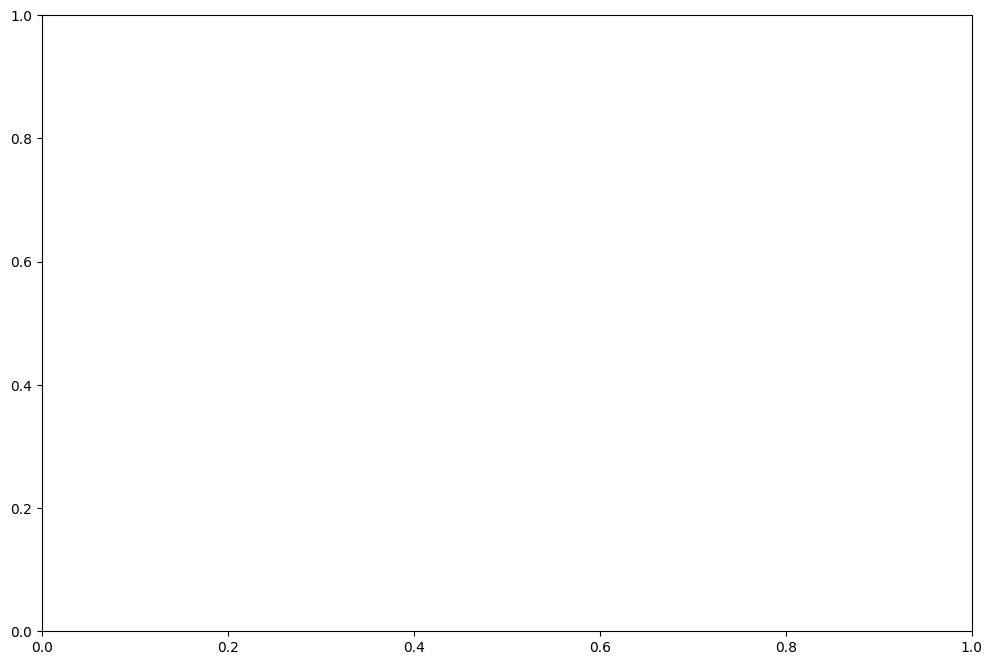

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
ndvi.mean(dim='time').plot(cmap='Greens', ax = ax)
plt.title(f'NDVI Average Pixel Value\nBetween {start.strftime("%Y-%m-%d")} and {stop.strftime("%Y-%m-%d")}')
ax.set_axis_off()
plt.show()